<a href="https://colab.research.google.com/github/abhi9716/Emojinator/blob/master/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !cp -r "/content/drive/My Drive/emojifier/dataset" /content

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras import applications
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

# dimensions of our images.
img_width, img_height = 100, 100
train_data_dir = '/content/dataset/train'
validation_data_dir = '/content/dataset/test'
nb_train_samples = 3510
nb_validation_samples = 1500
epochs = 15
batch_size = 64

Using TensorFlow backend.


In [10]:
import tensorflow as tf; print(tf.__version__)

2.2.0


In [3]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(100, 100),  # all images will be resized to 100x100
        batch_size=batch_size,color_mode="grayscale"
        )  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100, 100),
        batch_size=batch_size,color_mode="grayscale"
       )

Found 3510 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [4]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [5]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[learning_rate_reduction]
    )

Epoch 1/15
54/54 [==============================] - 9s 168ms/step - loss: 1.9315 - accuracy: 0.3157 - val_loss: 0.5874 - val_accuracy: 0.8505
Epoch 2/15
54/54 [==============================] - 5s 102ms/step - loss: 0.6814 - accuracy: 0.7754 - val_loss: 0.1468 - val_accuracy: 0.9568
Epoch 3/15
54/54 [==============================] - 5s 100ms/step - loss: 0.3816 - accuracy: 0.8807 - val_loss: 0.1004 - val_accuracy: 0.9721
Epoch 4/15
54/54 [==============================] - 5s 101ms/step - loss: 0.2647 - accuracy: 0.9196 - val_loss: 0.0200 - val_accuracy: 0.9847
Epoch 5/15
54/54 [==============================] - 5s 101ms/step - loss: 0.1899 - accuracy: 0.9405 - val_loss: 0.0131 - val_accuracy: 0.9896
Epoch 6/15
54/54 [==============================] - 5s 101ms/step - loss: 0.1540 - accuracy: 0.9544 - val_loss: 0.0872 - val_accuracy: 0.9889
Epoch 7/15
54/54 [==============================] - 5s 100ms/step - loss: 0.1400 - accuracy: 0.9568 - val_loss: 0.0213 - val_accuracy: 0.9840
Epoch 

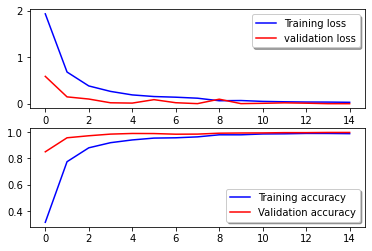

In [6]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [7]:
from PIL import Image
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (100, 100, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load("/content/dataset/test/1/1.jpg")

results = model.predict(image)

In [8]:
np.argmax(results,axis = 1)

array([1])

In [9]:
model.save_weights('/content/drive/My Drive/emojifier/model.h5')